- 2021/05/31, u.k. , produced according to Prof. ichimoto's presentation file
- 2021/06/07, u.k. , fixed bugs, now we are able to reproduce Prof. ichimoto's result
- 2021/06/08, u.k. k.i. , fixed um=0.1 -> um = variable 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

from spectra_src.ImportAll import *
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

## Model Atmosphere

In [6]:
from spectra_src.Struct import Atmosphere

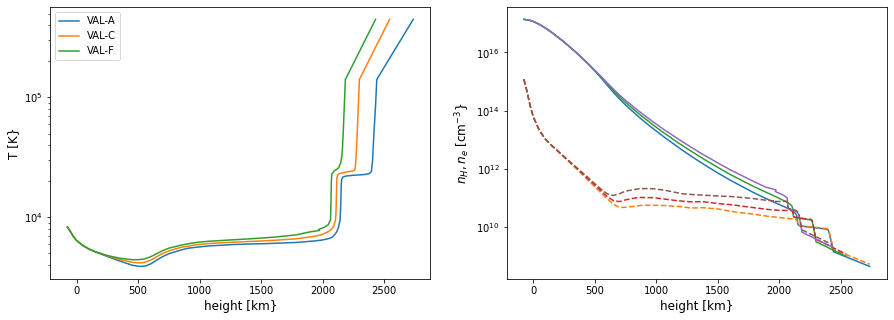

In [7]:

atmos = [ Atmosphere.init_VAL_(val_type) for val_type in ('A', 'C', 'F') ]

fig,axs = plt.subplots(1,2,figsize=[15,5])
ax1=axs[0]
for atm in atmos:
    ax1.plot(atm.Z[:]*1E-5, atm.Te[:], label=atm.model)
ax1.set_yscale("log")
ax1.set_xlabel('height [km}',fontsize=12)
ax1.set_ylabel('T [K}',fontsize=12)
ax1.legend()

ax2=axs[1]
for atm in atmos:
    ax2.plot(atm.Z[:]*1E-5, atm.Nh[:], label=atm.model)
    ax2.plot(atm.Z[:]*1E-5, atm.Ne[:], '--',label=atm.model)
ax2.set_yscale("log")
ax2.set_xlabel('height [km}',fontsize=12)
ax2.set_ylabel('$n_H, n_e$ [cm$^{-3}$}',fontsize=12)


plt.show()

In [8]:
valc = atmos[1]

from spectra_src.Util.HelpUtil import help_
help_(valc)

------------------------------------------------------------------------------------------
name                       type                                 value/len/shape
------------------------------------------------------------------------------------------
AtmosphereC1D
|- model                   str                                      v: VAL-C...
|- Nh                      ndarray                              s: (52,)
|- Ne                      ndarray                              s: (52,)
|- Te                      ndarray                              s: (52,)
|- Vd                      ndarray                              s: (52,)
|- Vt                      ndarray                              s: (52,)
|- Z                       ndarray                              s: (52,)
|- tau5                    ndarray                              s: (52,)
|- column_mass             ndarray                              s: (52,)
|- is_uniform              bool                             

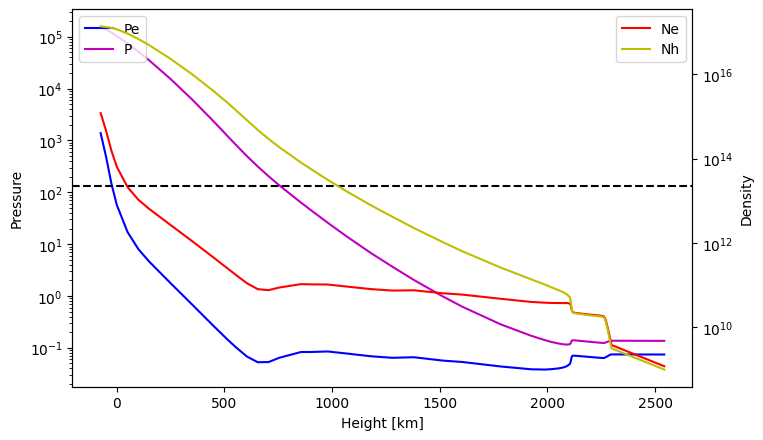

In [21]:
ph = valc.Nh[:]) * valc.Te[:] * CST.k_
pe = valc.Ne[:] * valc.Te[:] * CST.k_

fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
ax.plot(valc.Z[:]*1E-5, pe[:], "b-", label="Pe")
ax.plot(valc.Z[:]*1E-5, p[:], "m-", label="P")
ax.set_yscale("log")
ax.set_xlabel("Height [km]")
ax.set_ylabel("Pressure")
ax.legend(loc="upper left")
ax2 = ax.twinx()
#ax2.plot(valc.Z[:]*1E-5, valc.Te[:], "r-")
#ax2.set_ylabel("Temperature")
ax2.plot(valc.Z[:]*1E-5, valc.Ne[:], "r-", label="Ne")
ax2.plot(valc.Z[:]*1E-5, valc.Nh[:], "y-", label="Nh")
ax2.set_ylabel("Density")
ax2.set_yscale("log")
ax2.legend(loc="upper right")
ax.axhline(y=131, linestyle="--", color="black")
plt.show()

---

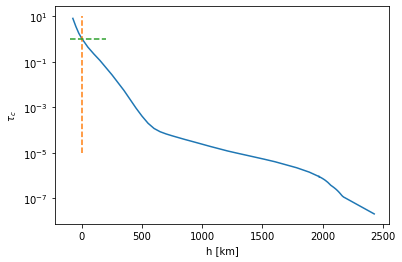

In [11]:
fig,ax = plt.subplots(1,1)
ax.plot(atm.Z[:]*1E-5, atm.tau5[:])
ax.set_yscale('log')
ax.set_ylabel(r'$\tau_c$')
ax.set_xlabel('h [km]')
ax.plot([0,0],[1e-5,1e1],'--')
ax.plot([-100,200],[1,1],'--')
plt.show()

## LTE continuum intensity

$I(\lambda)=\int{B(\lambda)\exp(-\tau)d\tau}$

In [12]:
from scipy import interpolate
from spectra_src.Atomic import LTELib
from spectra_src.Experimental import ExLTELib as _LTELib
from spectra_src.Atomic import ContinuumOpacity

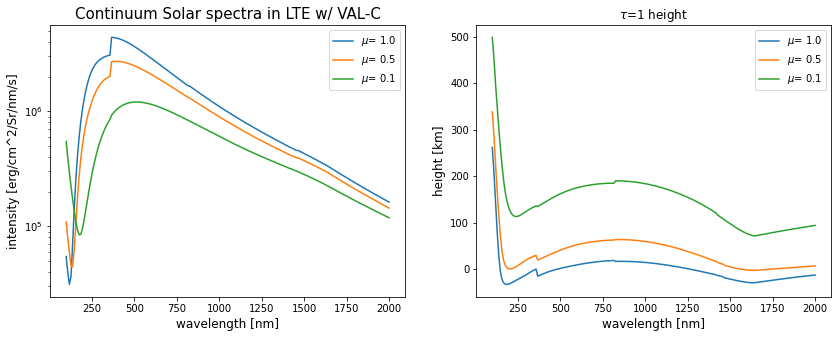

In [13]:
#  continuum spectra

nw = 200
wl = np.linspace(100,2000,nw) *1e-7  # cm
um = [1., 0.5, 0.1]      # cos(th)

atm = Atmosphere.init_VAL_('C')

nZ = atm.Z[:].shape[0]
xc = np.zeros([nw,nZ])

for i in range(0,nw):
    xc[i,:] = ContinuumOpacity.H_LTE_continuum_opacity_( atm.Te[:], atm.Ne[:], atm.Nh[:], wl[i] )

nu = len(um)
intens = np.zeros([nw,nu])
h_tau1 = np.zeros([nw,nu])
for j in range(0,nu):
    um1 = um[j]
    for i in range(0,nw):
        intens1, cntrb, tauc = _LTELib.lte_integ_( atm.Z[:], atm.Te[:], xc[i,:], wl[i], um1 )
        intens[i,j] = intens1/1e8  # [erg/cm^2/Sr/nm/s]
        hf = interpolate.interp1d(tauc, atm.Z[:]*1E-5, kind='cubic')
        h_tau1[i,j] = hf(1.)

fig,axs = plt.subplots(1,2,figsize=[14,5])
ax=axs[0]
for j in range(0,nu):
    um1 = um[j]
    ax.plot(wl*1e7,intens[:,j],label=r'$\mu$='+f'{um1:4.1f}')

ax.set_xlabel('wavelength [nm]',fontsize=12)
ax.set_ylabel('intensity [erg/cm^2/Sr/nm/s]',fontsize=12)
ax.set_yscale('log')
ax.set_title('Continuum Solar spectra in LTE w/ '+atm.model,fontsize=15)
ax.legend()

ax=axs[1]
for j in range(0,nu):
    um1 = um[j]
    ax.plot(wl*1e7,h_tau1[:,j],label=r'$\mu$='+f'{um1:4.1f}')

ax.set_xlabel('wavelength [nm]',fontsize=12)
ax.set_ylabel('height [km]',fontsize=12)
ax.set_title(r'$\tau$=1 height')
ax.legend()

plt.show()

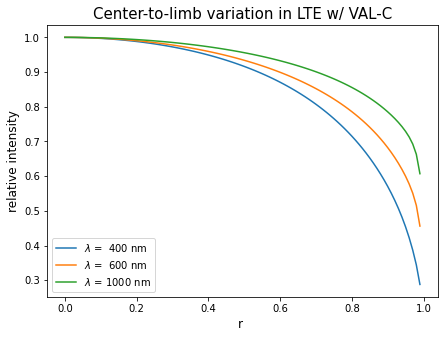

In [14]:
#  center-to-limb variation

wl = np.array([400,600,1000])  *1e-7   # nm
nr = 100
r = np.linspace(0,0.99,nr)      # cos(th)
um = np.sqrt(1-r**2)
nw = len(wl)

atm = Atmosphere.init_VAL_('C')

nn = len(atm.Z)
xc = np.zeros([nw,nn])

for i in range(0,nw):
    xc[i,:] = ContinuumOpacity.H_LTE_continuum_opacity_( atm.Te[:], atm.Ne[:], atm.Nh[:], wl[i] )

nu = len(um)
intens = np.zeros([nw,nr])
h_tau1 = np.zeros([nw,nr])
for i in range(0,nw):
    wl1 = wl[i]
    for j in range(0,nu):
        um1 = um[j]
        intens1, cntrb, tauc = _LTELib.lte_integ_( atm.Z[:], atm.Te[:], xc[i,:], wl1, um1 )
        #intens1, cntrb, tauc = lteinteg(a.h,a.T,xc[i,:],wl1,um1)
        intens[i,j] = intens1 * 1e-7  # [erg/cm^2/Sr/nm/s]

        
fig,ax = plt.subplots(1,1,figsize=[7,5])
for i in range(0,nw):
    ax.plot(r,intens[i,:]/intens[i,0],label=r'$\lambda$ ='+f'{wl[i]*1e7:5.0f} nm')

ax.set_xlabel('r ',fontsize=12)
ax.set_ylabel('relative intensity',fontsize=12)
ax.set_title('Center-to-limb variation in LTE w/ '+atm.model,fontsize=15)
ax.legend()
plt.show()

 

# Spectral line in LTE

In [15]:
from spectra_src.Experimental import ExLine as _Line
from spectra_src.Util import HelpUtil

Text(0.5, 1.0, 'Fe_I  6302.5 A')

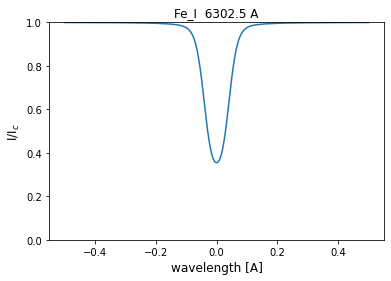

In [16]:
# line profile

atm = Atmosphere.init_VAL_('C')
l = _Line.Line(
    ion   = "Fe_I",
    wl0   = 630.25 * 1E-7, # [cm]
    ep    = 3.686 * CST.eV2erg_, # [erg]
    gf    = 0.0316,
    gamma = 0.1,
)
#l = LineCls()
#l.setValues(elm = 'Fe_I', wl0 = 630.25 *1e-7, ep = 3.686, gf =  0.0316*1000, gamma = 0.1)
wl = np.linspace(-0.5,0.5,201) * 1e-8  #  [AA] -> [cm]
um = 1.

prof, ic, cntrb = _LTELib.line_prof_lte_( atm, l, wl, um )
#prof, ic, cntrb = lprof(a, l, wl, um)

fig, ax = plt.subplots(1,1)
ax.plot(wl*1e8, prof/ic)
ax.set_xlabel('wavelength [A]', fontsize=12)
ax.set_ylabel('I/I$_c$', fontsize=12)
ax.set_ylim([0,1])
ax.set_title(l.ion+f' {l.wl0*1e8:7.1f} A')


In [17]:
HelpUtil.help_(atm)

------------------------------------------------------------------------------------------
name                       type                                 value/len/shape
------------------------------------------------------------------------------------------
AtmosphereC1D
|- model                   str                                      v: VAL-C...
|- Nh                      ndarray                              s: (52,)
|- Ne                      ndarray                              s: (52,)
|- Te                      ndarray                              s: (52,)
|- Vd                      ndarray                              s: (52,)
|- Vt                      ndarray                              s: (52,)
|- Z                       ndarray                              s: (52,)
|- tau5                    ndarray                              s: (52,)
|- is_uniform              bool                                 v: False
|- ndim                    int                              

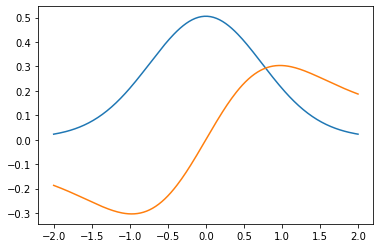

In [18]:
a=0.1
x = np.linspace(-2, 2, 201)
from spectra_src.RadiativeTransfer import Profile
h, f = Profile.hf_(a, x)
plt.plot(x,h)
plt.plot(x,f)

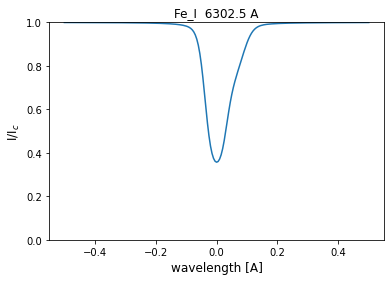

In [19]:
atm.Vd[:]=0.
atm.Vd[0:5]=2.E5  # [cm]
prof, ic, contrib = _LTELib.line_prof_lte_( atm, l, wl, um )

fig, ax = plt.subplots(1,1)
ax.plot(wl*1e8, prof/ic)
ax.set_xlabel('wavelength [A]', fontsize=12)
ax.set_ylabel('I/I$_c$', fontsize=12)
ax.set_ylim(0,1)
ax.set_title(l.ion+f' {l.wl0*1e8:7.1f} A')
plt.show()

In [20]:
import matplotlib

from spectra_src.Visual import Plotting

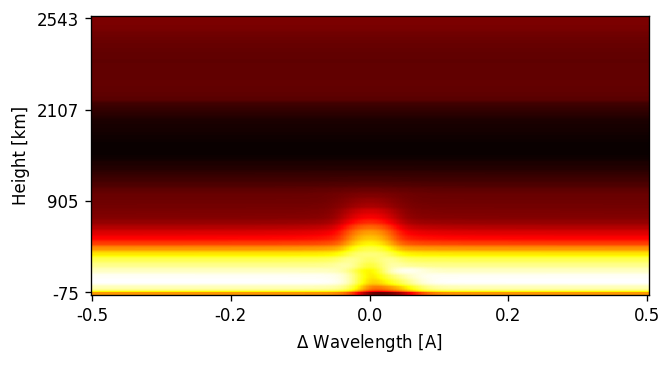

In [21]:
fig, ax = plt.subplots(1,1,dpi=120)

ax.imshow(contrib.T, cmap="hot", origin="lower",
          norm=matplotlib.colors.LogNorm(vmin=contrib.min(), vmax=contrib.max())
         )
ax.set_aspect( contrib.shape[0]/contrib.shape[1]*0.5 )
Plotting.set_imshow_ticks_(ax, atm.Z[:]*1E-5, 'y', points=4, fmt='%.0f', rot=0)
Plotting.set_imshow_ticks_(ax, wl[:]*1E8, 'x', points=5, fmt='%.1f', rot=0)
ax.set_ylabel("Height [km]")
ax.set_xlabel("$\Delta$ Wavelength [A]")
plt.show()